In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm, LogNorm
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import sklearn
from cmcrameri import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle, FancyBboxPatch
from matplotlib.lines import Line2D
from sklearn import linear_model
from sklearn.feature_selection import f_regression

import sys
sys.path.append('../')
import snowFun

In [2]:
import importlib
importlib.reload(snowFun)

<module 'snowFun' from 'C:\\Users\\lzell\\OneDrive - Colostate\\Desktop\\AGVA\\scripts\\Figures\\..\\snowFun\\__init__.py'>

In [3]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_cloud = os.path.join(folder_AGVA, 'classified images', 'S2_Cloud_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")
folder_climate = os.path.join(folder_AGVA, "Climate")

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi, include_fields=['RGIId', 'geometry'])

# open the big data csv
path_data = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Final_Data_Table.csv')
data_df = pd.read_csv(path_data)

# subset rgi to the glaciers we have data for
rgi_gdf = rgi_gdf[ rgi_gdf['RGIId'].isin(data_df['RGIId']) ]
# print(rgi_gdf.columns)

# merge columns
all_data_gdf = gpd.GeoDataFrame(pd.merge(data_df, rgi_gdf, on="RGIId"))

# replace -9999 with nan
all_data_gdf[all_data_gdf==-9999] = np.nan

# replace "True" and "False" with 1/0
all_data_gdf.replace({"False": 0, "True": 1}, inplace=True)

# what columns are available?
print(all_data_gdf.shape)
print(all_data_gdf.columns.values)

(3002, 82)
['RGIId' 'GLIMSId' 'BgnDate' 'EndDate' 'CenLon' 'CenLat' 'O1Region'
 'O2Region' 'Area' 'Zmin' 'Zmax' 'Zmed' 'Slope' 'Aspect' 'Lmax' 'Status'
 'Connect' 'Form' 'TermType' 'Surging' 'Linkages' 'Name' 'O3Region'
 'O3_name' 'ela_2018' 'ela_2019' 'ela_2020' 'ela_2021' 'ela_2022'
 'aar_2018' 'aar_2019' 'aar_2020' 'aar_2021' 'aar_2022' 'off_glacier_2018'
 'off_glacier_2019' 'off_glacier_2020' 'off_glacier_2021'
 'off_glacier_2022' 'date_2018' 'date_2019' 'date_2020' 'date_2021'
 'date_2022' 'ela_avg_product' 'aar_avg_product' 'aar_infill_avg_product'
 'off_glacier_avg_product' 'percent_observed_average_product' 'dhdt_1520'
 'dhdt_1020' 'distance_from_ocean' 'hyps_ela' 'hyps_aar' 'hyps_aar_20'
 'hyps_aar_40' 'hyps_aar_60' 'hyps_aar_80' 'hyps_aar_100' 'hyps_aar_120'
 'hyps_aar_140' 'hyps_aar_160' 'hyps_aar_180' 'hyps_aar_200'
 'hyps_aar_220' 'hyps_aar_240' 'hyps_aar_260' 'hyps_aar_280'
 'hyps_aar_300' 'hyps_aar_320' 'hyps_aar_340' 'hyps_aar_360'
 'hyps_aar_380' 'hyps_aar_400' 'hyps_a

In [4]:
# add column for accumulation area of each glacier
all_data_gdf['aa_avg_product'] = all_data_gdf['aar_infill_avg_product']*all_data_gdf['Area']

for y in [2018,2019,2020,2021,2022]:
    all_data_gdf[f"aa_{y}"] = all_data_gdf[f"aar_{y}"]*all_data_gdf['Area']

In [5]:
### calculate each glacier's ELA, AAR variation from ela_avg_product in each year
# note that AAR can be calculated as magnitude or percent
for y in [2018,2019,2020,2021,2022]:
    all_data_gdf[f"ela_anom_{y}"] = all_data_gdf[f"ela_{y}"]-all_data_gdf["ela_avg_product"]
    all_data_gdf[f"aar_anom_{y}_mag"] = all_data_gdf[f"aar_{y}"]-all_data_gdf["aar_avg_product"]
    all_data_gdf[f"aar_anom_{y}_per"] = all_data_gdf[f"aar_anom_{y}_mag"]/all_data_gdf["aar_avg_product"]

# calculate the range in ela, aar that each glacier exhibits
all_data_gdf[f"ela_range"] = all_data_gdf[[f"ela_anom_{y}" for y in range(2018,2023)]].max(axis=1) - all_data_gdf[[f"ela_anom_{y}" for y in range(2018,2023)]].min(axis=1)
all_data_gdf[f"aar_range_mag"] = all_data_gdf[[f"aar_anom_{y}_mag" for y in range(2018,2023)]].max(axis=1) - all_data_gdf[[f"aar_anom_{y}_mag" for y in range(2018,2023)]].min(axis=1)
all_data_gdf[f"aar_range_per"] = all_data_gdf[[f"aar_anom_{y}_per" for y in range(2018,2023)]].max(axis=1) - all_data_gdf[[f"aar_anom_{y}_per" for y in range(2018,2023)]].min(axis=1)

In [6]:
# add column for the total glacier area in each O2Region
temp = all_data_gdf.groupby('O2Region')['Area'].sum().rename('O2Region_area')
all_data_gdf = gpd.GeoDataFrame(pd.merge(all_data_gdf, temp, on="O2Region"))

# add column for the total glacier area in each O3Region
temp = all_data_gdf.groupby('O3Region')['Area'].sum().rename('O3Region_area')
all_data_gdf = gpd.GeoDataFrame(pd.merge(all_data_gdf, temp, on="O3Region"))

In [7]:
# open o3 climate data
path_o3c = os.path.join(folder_climate, "O3Regions", f'O3Region_anomalies.csv')
df_o3c = pd.read_csv(path_o3c)

# scale all precip columns by 100
p_cols = [c for c in df_o3c.columns if 'precip' in c]
df_o3c[p_cols] = df_o3c[p_cols]*100
df_o3c

,O3Region,temperature_2m_s_anom_2018,temperature_2m_w_anom_2018,total_precipitation_sum_s_anom_2018,total_precipitation_sum_w_anom_2018,snowfall_sum_s_anom_2018,snowfall_sum_w_anom_2018,temperature_2m_s_anom_2019,temperature_2m_w_anom_2019,total_precipitation_sum_s_anom_2019,...,total_precipitation_sum_s_anom_2021,total_precipitation_sum_w_anom_2021,snowfall_sum_s_anom_2021,snowfall_sum_w_anom_2021,temperature_2m_s_anom_2022,temperature_2m_w_anom_2022,total_precipitation_sum_s_anom_2022,total_precipitation_sum_w_anom_2022,snowfall_sum_s_anom_2022,snowfall_sum_w_anom_2022
0,1,-0.707480,0.660416,29.525605,0.168927,-0.690267,0.001626,1.734656,2.606717,-38.653998,...,-3.747908,1.237845,1.777100,0.155175,-0.277044,-0.001954,13.734589,9.231736,0.263489,0.008511
1,2,-1.252648,0.390521,27.567868,-21.742548,0.281744,-0.216486,2.361325,2.672938,-48.768173,...,0.402501,-11.045603,1.162451,-0.104474,0.040777,1.949022,21.897168,44.703701,-0.375123,0.452109
2,3,-1.054278,0.290863,10.351881,-12.359106,0.382265,-0.123202,2.119753,2.818634,-24.285550,...,-8.060828,-12.375667,0.249125,-0.122571,-0.038664,1.526594,13.547551,28.814384,0.284262,0.289905
3,4,-0.978044,0.513510,21.362982,-24.376494,0.295218,-0.241470,1.787634,2.685898,-35.141147,...,-6.713968,-27.538141,0.100406,-0.272132,0.117229,1.497102,21.145784,33.154614,0.358061,0.335672
4,5,-0.819291,0.465727,8.574938,-6.649183,0.270510,-0.066863,1.352444,2.916025,-17.900646,...,-2.623382,-33.225261,0.055928,-0.332889,0.276668,1.277913,5.019644,62.283653,-0.062463,0.624929
5,6,-0.301143,-0.219524,16.912313,-2.682063,0.159709,-0.028908,0.863056,2.398607,-23.643726,...,1.589603,-24.326549,0.118508,-0.241982,0.248437,1.764552,6.104154,56.619566,0.134548,0.570653
6,7,-1.028360,0.368656,4.041469,-7.487060,0.515925,-0.074628,1.982614,2.609258,-17.857936,...,-6.248643,-18.341029,-0.019799,-0.183218,0.140553,1.448447,15.924576,51.035349,-0.117360,0.511913
7,8,-1.143957,0.143373,16.853091,-17.928790,-0.879676,-0.179896,2.452668,2.043722,-57.064469,...,-4.853136,-2.523785,3.517791,-0.004191,-0.061166,1.501742,37.598610,40.114790,-1.000000,0.425159
8,9,-1.179631,0.362103,7.316142,-18.394971,-0.251420,-0.195240,2.702869,1.707186,-59.241372,...,-7.951286,-1.814946,2.284663,0.015755,-0.019311,2.085120,40.297863,43.178580,-1.000000,0.476494
9,10,-1.078803,-0.011179,35.763951,-15.719748,0.638433,-0.170751,2.129428,1.943970,-64.671947,...,1.579206,-16.798371,0.177226,-0.154445,0.133886,1.952402,38.962468,36.951249,0.234895,0.386163


### calculate the region-average ela, aar variation each year

In [8]:
# start by getting the full geometry for each subregion. keep this stored in a separate gdf for later
# O3_geom = all_data_gdf[['geometry', 'O3Region']].dissolve(by='O3Region').reset_index()

In [9]:
# calculating total glacier number, glacier area, mean and median size, aa, and aar for each region
o3_df = pd.DataFrame(all_data_gdf.groupby('O3Region')['Area'].count().rename('number'))
o3_df['area'] = all_data_gdf.groupby('O3Region')['Area'].sum()
o3_df['aa'] = all_data_gdf.groupby('O3Region')['aa_avg_product'].sum()
o3_df['aar'] = o3_df['aa']/o3_df['area']

In [10]:
# calculate aar each year
for y in [2018,2019,2020,2021,2022]:
    o3_df[f'aa_{y}'] = all_data_gdf.groupby('O3Region')[f'aa_{y}'].sum()
    o3_df[f'aar_{y}'] = o3_df[f'aa_{y}']/o3_df['area']

In [11]:
### calculate average elas each year, for glaciers where ela was observed
for y in [2018,2019,2020,2021,2022]:
    # for this year, subset to valid ela obs
    temp = all_data_gdf[all_data_gdf[f'off_glacier_{y}']==0]
    o3_df[f'ela_mean_{y}'] = temp.groupby('O3Region')[f'ela_{y}'].mean()
    o3_df[f'ela_median_{y}'] = temp.groupby('O3Region')[f'ela_{y}'].median()
    
    # do the same, but only for larger glaciers (5km2 or bigger)
    temp = all_data_gdf[ (all_data_gdf[f'off_glacier_{y}']==0) & (all_data_gdf['Area']>=5) ]
    o3_df[f'ela_5km_mean_{y}'] = temp.groupby('O3Region')[f'ela_{y}'].mean()
    o3_df[f'ela_5km_median_{y}'] = temp.groupby('O3Region')[f'ela_{y}'].median()

In [12]:
### also calculate the average ela using the average product
temp = all_data_gdf[all_data_gdf[f'off_glacier_{y}']==0]
o3_df[f'ela_mean'] = temp.groupby('O3Region')[f'ela_avg_product'].mean()
o3_df[f'ela_median'] = temp.groupby('O3Region')[f'ela_avg_product'].median()

temp = all_data_gdf[ (all_data_gdf[f'off_glacier_{y}']==0) & (all_data_gdf['Area']>=5) ]
o3_df[f'ela_5km_mean'] = temp.groupby('O3Region')[f'ela_avg_product'].mean()
o3_df[f'ela_5km_median'] = temp.groupby('O3Region')[f'ela_avg_product'].median()

# get ela, aar anomaly each year
for y in [2018,2019,2020,2021,2022]:
    o3_df[f'ela_anom_{y}'] = o3_df[f'ela_median_{y}'] - o3_df[f'ela_median']
    o3_df[f'ela_5km_anom_{y}'] = o3_df[f'ela_5km_median_{y}'] - o3_df[f'ela_5km_median']
    o3_df[f'aar_anom_{y}'] = o3_df[f'aar_{y}'] - o3_df['aar']
    
# add climate
o3_df = pd.merge(o3_df, df_o3c, on="O3Region")
    
# add geometry in at the end
# o3_df = gpd.GeoDataFrame(pd.merge(o3_df, O3_geom, on="O3Region"))

# remove the glaciers in O3Region=0 (these are glaciers that don't fit into any of the regions)
o3_df = o3_df.drop(0, axis=0)
o3_df.columns

Index(['O3Region', 'number', 'area', 'aa', 'aar', 'aa_2018', 'aar_2018',
       'aa_2019', 'aar_2019', 'aa_2020', 'aar_2020', 'aa_2021', 'aar_2021',
       'aa_2022', 'aar_2022', 'ela_mean_2018', 'ela_median_2018',
       'ela_5km_mean_2018', 'ela_5km_median_2018', 'ela_mean_2019',
       'ela_median_2019', 'ela_5km_mean_2019', 'ela_5km_median_2019',
       'ela_mean_2020', 'ela_median_2020', 'ela_5km_mean_2020',
       'ela_5km_median_2020', 'ela_mean_2021', 'ela_median_2021',
       'ela_5km_mean_2021', 'ela_5km_median_2021', 'ela_mean_2022',
       'ela_median_2022', 'ela_5km_mean_2022', 'ela_5km_median_2022',
       'ela_mean', 'ela_median', 'ela_5km_mean', 'ela_5km_median',
       'ela_anom_2018', 'ela_5km_anom_2018', 'aar_anom_2018', 'ela_anom_2019',
       'ela_5km_anom_2019', 'aar_anom_2019', 'ela_anom_2020',
       'ela_5km_anom_2020', 'aar_anom_2020', 'ela_anom_2021',
       'ela_5km_anom_2021', 'aar_anom_2021', 'ela_anom_2022',
       'ela_5km_anom_2022', 'aar_anom_2022', 't

In [13]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


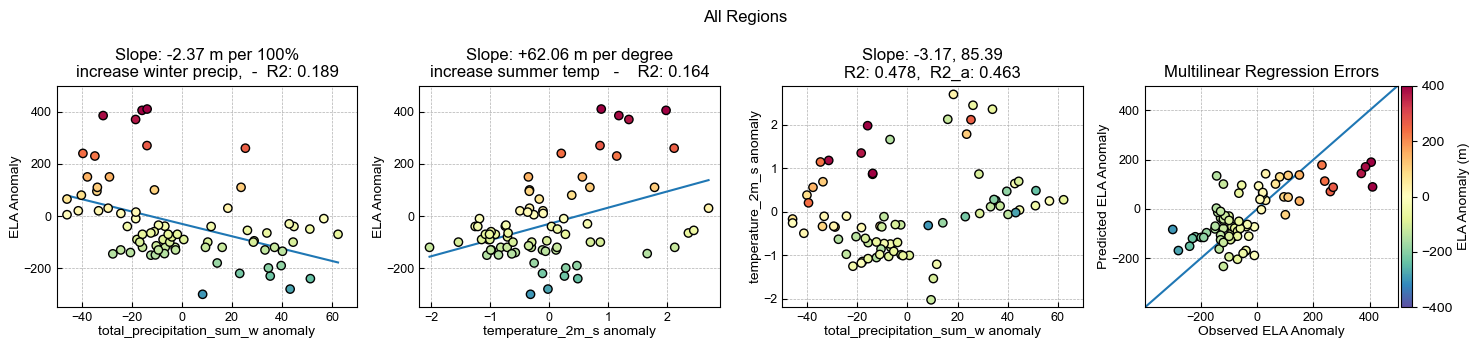

In [14]:
# plot o3region climate anomalies vs ELA anomaly
fig,axs = plt.subplots(1,4, figsize=(15,3.5), dpi=100)

ax1,ax2,ax3,ax4 = axs

#"temperature_2m_s", "temperature_2m_w", "total_precipitation_sum_s", "total_precipitation_sum_w", "snowfall_sum_s", "snowfall_sum_w"
target_climate_x = "total_precipitation_sum_w"  
target_climate_y = "temperature_2m_s"
target_response = "ela_anom" #ela_5km_anom ela_5km_mean

# subset to specific regions if you want

# define which subregions to group
region_dic = {'Alaska Range':[2,3,4,5,6],
              'West Chugach Mountains':[7,8,9,10],
              'Saint Elias Mountains':[11,12],
              'North Coast Ranges':[13,14,15,16],
              'All Regions':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],
              'Coastal Regions':[8,9,10,11,12,13,14,15,16],
              'Interior Regions':[3,4,5,6,7]}

region_name = 'All Regions'
region_numbers = region_dic[region_name]
df_to_use = o3_df[o3_df['O3Region'].isin(region_numbers)]

allx1 = []
allx2 = []
ally = []

years = [2018,2019,2020,2021,2022]
for year in years: #ela_5km_anom_2020
    xs = df_to_use[f'{target_climate_x}_anom_{year}']
    ys = df_to_use[f'{target_climate_y}_anom_{year}']
    colors = df_to_use[f'{target_response}_{year}']
    sc = ax1.scatter(xs, colors, c=colors,
                     vmin=-400, vmax=400, cmap="Spectral_r", zorder=5, edgecolor='black')
    sc = ax2.scatter(ys, colors, c=colors, 
                     vmin=-400, vmax=400, cmap="Spectral_r", zorder=5, edgecolor='black')
    sc = ax3.scatter(xs, ys, c=colors, 
                     vmin=-400, vmax=400, cmap="Spectral_r", zorder=5, edgecolor='black')
    
    allx1 = allx1 + list(xs.values)
    allx2 = allx2 + list(ys.values)
    ally = ally + list(colors.values)

# define x/y ranges
p_range = [-50,70]
t_range = [-2.2,2.9]
ela_range = [-350,499]

# set tick and label stuff
ax1.set_xlabel(f"{target_climate_x} anomaly", fontsize = 10, labelpad=1)
ax1.set_ylabel(f"ELA Anomaly", fontsize = 10, labelpad=1)
ax1.set_xlim(p_range)
ax1.set_ylim(ela_range)

ax2.set_xlabel(f"{target_climate_y} anomaly", fontsize = 10, labelpad=1)
ax2.set_ylabel(f"ELA Anomaly", fontsize = 10, labelpad=1)
ax2.set_xlim(t_range)
ax2.set_ylim(ela_range)

ax3.set_xlabel(f"{target_climate_x} anomaly", fontsize = 10, labelpad=1)
ax3.set_ylabel(f"{target_climate_y} anomaly", fontsize = 10, labelpad=1)
ax3.set_xlim(p_range)
ax3.set_ylim(t_range)

for ax in axs:
    ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)
    ax.tick_params(axis='both', direction='in', labelsize=9)

# make into df quickly
df_reg = pd.DataFrame({target_climate_x:allx1, target_climate_y:allx2, target_response:ally })


# calculate regression for winter precip
X = df_reg[[target_climate_x]]
y = df_reg[target_response]
regr = linear_model.LinearRegression(fit_intercept=True) # no intercept fit because we want it to pass through 0,0
regr.fit(X, y)
mm = np.array([np.nanmin(allx1), np.nanmax(allx1)]).reshape(-1,1)
ax1.plot(mm, regr.predict(mm))

slope = regr.coef_
r2 = regr.score(X,y)
ax1.set_title(f"Slope: {round(slope[0],2)} m per 100%\nincrease winter precip,  -  R2: {round(r2,3)}")


# calculate regression for summer temp
X = df_reg[[target_climate_y]]
y = df_reg[target_response]
regr = linear_model.LinearRegression(fit_intercept=True) # no intercept fit because we want it to pass through 0,0
regr.fit(X, y)
mm = np.array([np.nanmin(allx2), np.nanmax(allx2)]).reshape(-1,1)
ax2.plot(mm, regr.predict(mm))

slope = regr.coef_
r2 = regr.score(X,y)
ax2.set_title(f"Slope: +{round(slope[0],2)} m per degree\nincrease summer temp   -    R2: {round(r2,3)}")



# calculate regression for 2 parameters
X = df_reg[[target_climate_x, target_climate_y]]
y = df_reg[target_response]
regr = linear_model.LinearRegression(fit_intercept=True) # no intercept fit because we want it to pass through 0,0
regr.fit(X, y)
slope = regr.coef_
r2 = regr.score(X,y)
r2_adj = 1 - (1-r2) * (len(y)-1)/(len(y)-X.shape[1]-1)
ax3.set_title(f"Slope: {round(slope[0],2)}, {round(slope[1],2)}\nR2: {round(r2,3)},  R2_a: {round(r2_adj,3)}")

# add real vs predicted in last subplots
real = y
predicted = regr.predict(X)
sc = ax4.scatter(real, predicted, c=ally, 
                     vmin=-400, vmax=400, cmap="Spectral_r", zorder=5, edgecolor='black')
ax4.plot([-500,500],[-500,500])

ax4.set_xlabel("Observed ELA Anomaly", fontsize = 10, labelpad=1)
ax4.set_ylabel("Predicted ELA Anomaly", fontsize = 10, labelpad=1)
ax4.set_xlim([-399,499])
ax4.set_ylim([-399,499])
ax4.set_title("Multilinear Regression Errors")

# add colorbar
plt.colorbar(sc, label='ELA Anomaly (m)', pad=0.01)    

# add figure title
plt.suptitle(region_name)
plt.tight_layout()

# for example: from model CESM2, scenario ssp245 - if wolverine increases winter precip by 17% and summer temp by 3 K:
# 0.17*-417 + 106*3 = 247 m rise

# for example: from model CESM2, scenario ssp585 - if wolverine increases winter precip by 54% and summer temp by 6 K:
# 0.54*-417 + 73*6 = 212 m rise

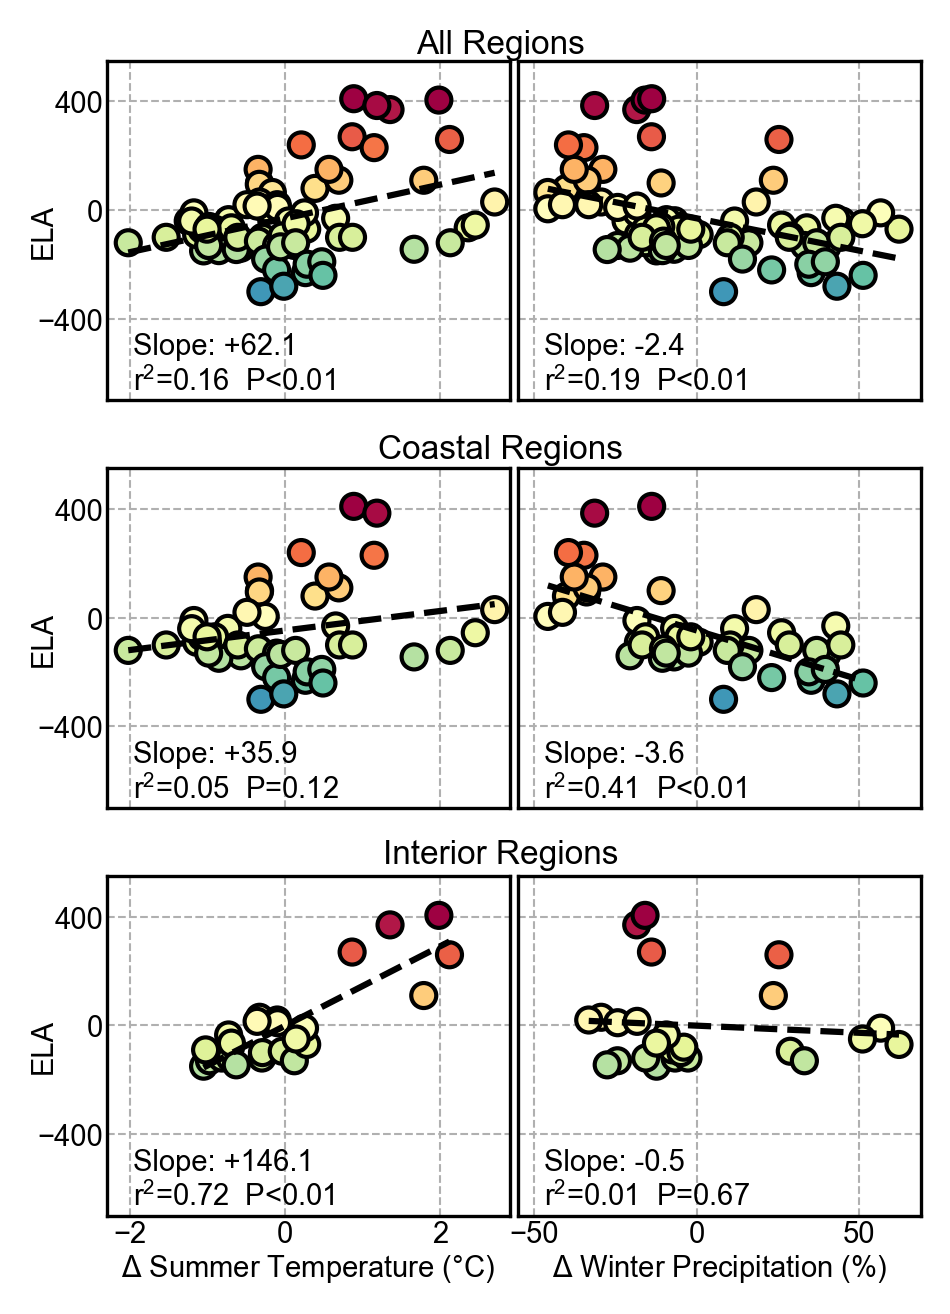

In [15]:
### lets focus in on the figure we want to make. one row for all glacier, one row for interior, one row for coastal

# define which subregions to group
region_dic = {'Alaska Range':[2,3,4,5,6],
              'West Chugach Mountains':[7,8,9,10],
              'Saint Elias Mountains':[11,12],
              'North Coast Ranges':[13,14,15,16],
              'All Regions':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],
              'Coastal Regions':[8,9,10,11,12,13,14,15,16],
              'Interior Regions':[3,4,5,6,7]}

# say which region each row will be for
row_regions = ['All Regions', 'Coastal Regions', 'Interior Regions']

# which parameters will each column look at
column_params = [["temperature_2m_s"], ["total_precipitation_sum_w"], ["temperature_2m_s", "total_precipitation_sum_w"] ]
column_names = ['$\Delta$ Summer Temperature ($\degree$C)', '$\Delta$ Winter Precipitation (%)']

# define the target param (what you are trying to predict)
target_response = "ela_anom" #ela_5km_anom ela_5km_mean
target_name = 'ELA'

# xlims for each columns
all_xlims = [[-2.3,2.9],[-55,69]]

# yticks
y_ticks = [-400,0,400]

# define some plotting info
vmin=-400
vmax=400
cmap='Spectral_r'

# initiate figure
fig, axs = plt.subplots(3,2, figsize=(3.5, 5), dpi=300, sharey=True, sharex='col')

# for each region
for r,region_name in enumerate(row_regions):
    
    # subset df
    region_numbers = region_dic[region_name]
    df_to_use = o3_df[o3_df['O3Region'].isin(region_numbers)]
    
    # for each parameters you want to use to predict
    for c,param in enumerate(column_params):
        
        # if there are multiple predictors, our approach will be slightly different
        if len(param)>1: continue
            
        # define which axis we are using
        ax = axs[r][c]
            
        # lists to hold data
        allx = []
        ally = []
        allc = []

        # get data for each year
        years = [2018,2019,2020,2021,2022]
        for year in years:

            xs = df_to_use[f'{param[0]}_anom_{year}']
            ys = df_to_use[f'{target_response}_{year}']
            colors = ys
            
            allx = allx + list(xs.values)
            ally = ally + list(ys.values)
            allc = allc + list(colors.values)
            
        # plot on the figure
        sc = ax.scatter(allx, ally, c=allc, vmin=vmin, vmax=vmax, cmap=cmap, zorder=5, edgecolor='black')
        
        # make into df quickly
        df_reg = pd.DataFrame({"x":allx, "y":ally, "color":allc })

        # calculate regression
        X = df_reg[['x']]
        y = df_reg['y']
        regr = linear_model.LinearRegression(fit_intercept=True) # no intercept fit because we want it to pass through 0,0?
        regr.fit(X.values, y.values)
        
        # plot regression
        mm = np.array([np.nanmin(allx), np.nanmax(allx)]).reshape(-1,1)
        ax.plot(mm, regr.predict(mm), c='black', linestyle='dashed', zorder=10)
        
        # get regression values
        slope = regr.coef_[0]
        r2 = regr.score(X.values,y.values)
        
        # get p-values
        freg=f_regression(X.values.reshape(-1, 1),np.array(y.values))
        p=freg[1][0].round(5)
        
        # format each
        if slope>0: slope_t = f"+{round(slope,1)}"
        else: slope_t = f"{round(slope,1)}"
        r2_t = round(r2,2)
        if p<0.01:
            p_text = "P<0.01"
        else:
            p_text = f"P={p.round(2)}"
        
        ax.text(0.065, 0.03, f"Slope: {slope_t}\nr$^2$={r2_t}  {p_text}", transform=ax.transAxes, fontsize=7)
#         ax.text(0.75, 0.2, f"Slope: {round(slope)}", transform=ax.transAxes)
#         ax2.set_title(f"Slope: +{round(slope[0],2)} m per degree\nincrease summer temp   -    R2: {round(r2,3)}")


#         slope = regr.coef_
#         r2 = regr.score(X,y)
#         ax1.set_title(f"Slope: {round(slope[0],2)} m per 100%\nincrease winter precip,  -  R2: {round(r2,3)}")
        
        # axis formatting
#         ax.set_title(region_name)
        ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)
        ax.tick_params(axis='both', direction='in', labelsize=7, pad=1, length=0)
        ax.set_ylim([-700,550])
        ax.set_yticks(y_ticks)
        ax.set_xlim(all_xlims[c])
#         ax.yaxis.tick_right()

axs[-1,0].set_xlabel(column_names[0], fontsize = 7, labelpad=1)
axs[-1,1].set_xlabel(column_names[1], fontsize = 7, labelpad=1)
axs[0,0].set_ylabel(target_name, fontsize = 7, labelpad=-5)
axs[1,0].set_ylabel(target_name, fontsize = 7, labelpad=-5)
axs[2,0].set_ylabel(target_name, fontsize = 7, labelpad=-5)

fig.subplots_adjust(hspace=0.2, wspace=0.02) 
fig.text(0.5,0.885, row_regions[0], ha='center', size=8)
fig.text(0.5,0.615, row_regions[1], ha='center', size=8)
fig.text(0.5,0.345, row_regions[2], ha='center', size=8)
# plt.tight_layout()

out_path = os.path.join(folder_AGVA, 'Figures', 'climatic drivers', 'climateb.png')
plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)